## BoxPlots First Place Model Documentation

* **Name**: XXXXXX
* **Location**: XXXXXX
* **Email**: XXXXXX
* **Competition**: BoxPlots for Education, hosted by DrivenData.org and sponsored by Educational Resource Strategies
* **Date**: Jan 10, 2015
* **Source Code Home**: https://github.com/drivendata/boxplots-for-education-1st-place/

## Summary

My model is based on Online Learning, specifically a Logistic Regression model that uses the hashing trick and stochastic gradient descent with an adaptive learning rate.  I owe a big debt of gratitude to <b><a href='http://www.kaggle.com/users/185835/tinrtgu' target='_'>tingrtu</a></b> for showing the effectiveness of this technique for multi-multi text classification in other competitions.  I started with tingrtu’s Python-based <b><a href='https://www.kaggle.com/c/tradeshift-text-classification/forums/t/10537/beat-the-benchmark-with-less-than-400mb-of-memory' target='_'>online learner</a></b>, and in addition I used Python/Pandas for Data Prep & EDA, then straight Python for Feature Engineering.

Feature Engineering for the text-based features was key for my model.   While I used some previously-proven techniques for creating 2-way and 3-way interactions between the original features, what made the biggest difference was decomposing the text features into tokens or single word features (which resulted in a jump from 0.52 to 0.43 on the public leaderboard).  This made it more likely that the model would correctly classify documents, even if the original feature text was coded slightly differently in different examples.


## Data Preparation

Data Prep was done using Python Pandas (see <a href='MakeDatasets.py' target='_'>MakeDatasets.py</a>).  The main work was to separate the training labels from the training predictors in TrainingData.csv.  This resulted in the files TrainingLabels.csv and TrainingPredictors.csv which are the actual files used for training.  


The columns in TestData.csv were re-ordered to match TrainPredictors.csv (important because we hash by column index).  The resulting file was TestData2.csv

## Feature Engineering

The following examples demonstrate the feature engineering strategy:

<table>
    <tr><th>Strategy</th><th>Feature Index</th><th>Feature Value</th><th>Features Generated</th><th>Feature Hash(es)</th><th>Notes</th></tr>
    <tr><td>Hash Original Feature Text</td><td>8</td><td>personnel-paid leave</td>
        <td>8_personnel-paid leave</td><td>73627</td><td>Hash original feature</td>
    </tr>
    <tr><td>Numeric Feature Binning</td><td>9</td><td>0.083331</td>
        <td>9_2</td><td>116563</td><td>"2" is the category for 0.083331</td>
    </tr>    
    <tr><td>Decompose Into Word Features</td><td>8</td><td>personnel-paid leave</td>
        <td>8_personnel<br/>8_paid<br/>8_leave<br/>personnel<br/>paid<br/>leave</td>
        <td>19350<br/>33659<br/>111721<br/>45143<br/>183246<br/>198768</td><td>Positioned and Unpositioned word feature hashes</td>
    </tr>
    <tr><td>Create 2-way and 3-way Feature Interactions</td><td>1 & 2</td><td>employee benefits & assigned pers/paid leaves</td>
        <td>employee benefits_x_assigned pers/paid leaves</td>
        <td>79594</td><td>Example of an interaction pair.  Interactions were discovered by intuition and semi-automated experimentation during cross-validation. </td>
    </tr>    
</table>

For the Feature Interactions above, these were the actual interactions used:

* pairs = [[1,2,3,4],[6,8],[4,12],[1,4,8,10]]
* triples = [[1,4,12]]

The numbers correspond to the feature indexes:

* Object_Description = 1
* Text_2 = 2
* SubFund_Description = 3
* Job_Title_Description = 4
* Text_3 = 5
* Text_4 = 6
* Sub_Object_Description = 7
* Location_Description = 8
* FTE = 9
* Function_Description = 10
* Facility_or_Department = 11
* Position_Extra = 12
* Total = 13
* Program_Description = 14
* Fund_Description = 15
* Text_1 = 16

Pairs are formed between members of each pair group.  For example [1,2,3,4] produces interactions 1-2, 2-3, 3-4, 2-3, and 3-4.

All text is lower-cased and spaces trimmed before hashing



## Model Details

A single <a href='Online.py' target='_'>Online Learning</a> model is used.  This is a Logistic Regression model using stochastic gradient descent with an adaptive learning rate.  The key characteristics of the model are:

* **Feature Hashing/Engineering**: Feature engineering and hashing scheme per previous section.
* **Adaptive Learning Rate**: Learning Rate (alpha) divided by sum of sqrt of gradients

The competition asks us to predict the probability of each possible value of 9 different target variables (Function, Use, etc).  This turns out to be 104 predictions that need to be made for each test example.  So essentially there are 104 models to fit.

The Online Learning model updates weights for each of the 104 models for each training example encountered.  The feature hashes are used as indexes for weights and gradients, and the adaptive learning rate helps to slow down weight updates as the SGD algorithm gets close to converging.


## Leaderboard Tracker

The figures below show how key model changes improved the public leaderboard score.

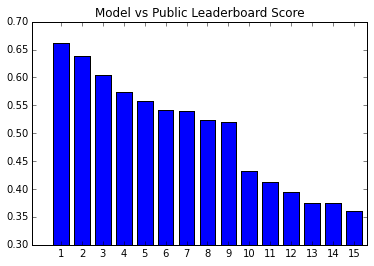

,Model,Score,Description
1,1,0.6619,Base Online Learning. Original features only. Hash space = 2**22
2,2,0.6388,Lower case text before hashing
3,3,0.6039,"Remove original variables 5,7,15,16"
4,4,0.5738,"Add back original variables 15,16"
5,5,0.5581,"Numerical binning 20 bins for Total, 5 for FTE. Also 2 epochs"
6,6,0.5416,"Pairwise interactions: [[1,2,3,4]]"
7,7,0.5391,"Pairwise interactions: [[1,2,3,4][6,8]]"
8,8,0.5240,"Pairwise interactions: [[1,2,3,4],[6,8],[4,12],[1,4,8,10]]"
9,9,0.5209,"Triple interaction: [1,4,12]"
10,10,0.4314,Decompose feature text into positioned word features.


In [79]:
# 15 key changes

The most important change was decomposing original text into word features.  Removing Text_3 (5) and Sub_Object_Description (7) also had a big effect. Clearly, there were also many small changes that contributed to final model performance.

## Running the Model

Prerequisites: python 2.7+, pypy 2.2.1, pandas 0.14.1

Scripts: <a href='MakeDatasets.py' target='_'>MakeDatasets.py</a>, <a href='Online.py' target='_'>Online.py</a>

1.  Download the 3 original datafiles (TrainingData.csv,TestData.csv,and SubmissionFormat.csv) to a folder called "origdata"
2.  Run "python MakeDatasets.py" - this command produces the training and test files TrainPredictors.csv, TrainLabels.csv, and TestData2.csv.
3.  Run "pypy Online.py 4 0.5" - note that pypy is required. This command fits an online logistic regression model, taking 4 passes/epochs over the training data with a 50% chance of using an encountered example in each epoch. (The effect of playing with epochs and use_example_probability is small for reasonable values - this is just an example configuration but the one used for the winning submission. Similar results can be obtained with 2 epochs and using 100% of examples in each pass).

The submission will then be placed in the file submission1234.csv. Score should be somewhere around 0.3665 (public leaderboard).
